In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torchvision.datasets as dset

%matplotlib inline

In [2]:
dataroot = "data/wiki_celebs"
batch_size = 128
image_size = 64
nc = 3 # number of channels in input image
nz = 100 # size of latent vector -> size of generator input
n_fm_g = 64 # number of feature maps in generator
n_fm_d = 64 # number of feature maps in discrimator
lr = 0.0001

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_url = "/content/drive/MyDrive/wiki_crop.tar" # path to zip file

In [5]:
import tarfile
my_tar = tarfile.open(zip_url)
print('Extracting all the files now...') 
my_tar.extractall('./data/wiki_celebs') # specify which folder to extract to
my_tar.close()
print('Done!') 

Extracting all the files now...
Done!


In [6]:
dataroot = './data/wiki_celebs/wiki_crop'

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size), #crops given image at the center
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #normalize the image with given mean and std_dev                           
                           ]))

In [8]:
dataset[1]

(tensor([[[-0.0039, -0.0902, -0.1922,  ..., -0.5451, -0.5529, -0.5294],
          [ 0.2000,  0.1294,  0.0431,  ..., -0.2549, -0.2627, -0.2471],
          [ 0.4196,  0.3882,  0.3176,  ...,  0.1529,  0.1451,  0.1686],
          ...,
          [-0.6549, -0.6784, -0.6784,  ..., -0.5373, -0.4745, -0.4980],
          [-0.6941, -0.6863, -0.6706,  ..., -0.5686, -0.5373, -0.5294],
          [-0.6941, -0.6863, -0.6627,  ..., -0.5922, -0.5843, -0.5529]],
 
         [[-0.7255, -0.8039, -0.8745,  ..., -0.8667, -0.8745, -0.8588],
          [-0.6078, -0.6706, -0.7333,  ..., -0.8353, -0.8431, -0.8275],
          [-0.5137, -0.5373, -0.5922,  ..., -0.7098, -0.7176, -0.6941],
          ...,
          [-0.0902, -0.1059, -0.0980,  ...,  0.0039,  0.0667,  0.0431],
          [-0.1294, -0.1216, -0.0902,  ..., -0.0275,  0.0039,  0.0118],
          [-0.1294, -0.1137, -0.0902,  ..., -0.0510, -0.0431, -0.0118]],
 
         [[-0.6941, -0.7882, -0.8824,  ..., -0.9922, -0.9922, -0.9765],
          [-0.6000, -0.6627,

In [9]:
len(dataset)

62328

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


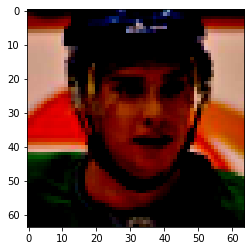

In [11]:
img, _ = dataset[1]
plt.imshow(img.permute(1, 2, 0))
# viewing a normalised image

In [13]:
def denorm(img_tensor):
  """Helper function to denormailze an image tensor"""
  return img_tensor*0.5 + 0.5

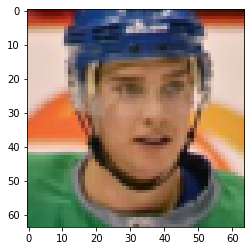

In [14]:
img, _ = dataset[1]
img = denorm(img)
plt.imshow(img.permute(1, 2, 0))
# denormalized version of same image

In [15]:
def show_batch(dl):
  """Show a batch of data from the dataloader"""
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(vutils.make_grid(images, nrow=16, normalize=True).permute(1, 2, 0))
    break

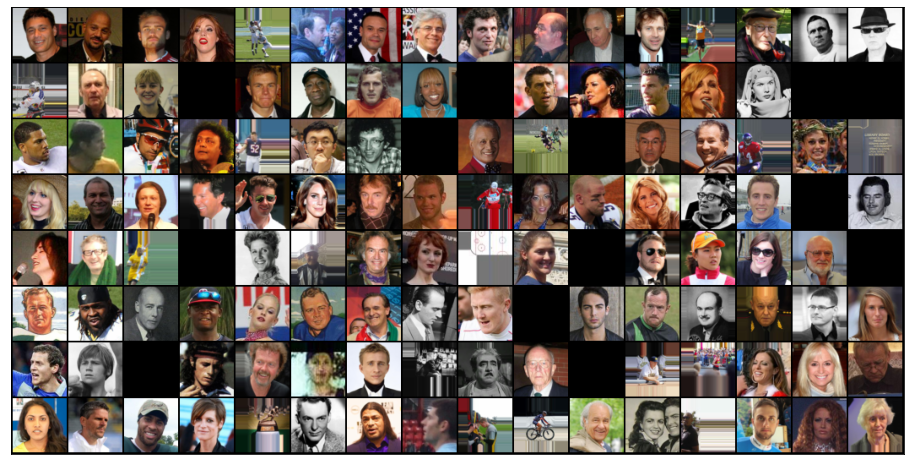

In [16]:
show_batch(dataloader)

In [17]:
def get_default_device():
  """Helper function to choose cuda gpu if available, else cpu"""
  if(torch.cuda.is_available):
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
dataloader = DeviceDataLoader(dataloader, device)

In [20]:
def weights_init(m):
  """Initialse the weights of the model"""
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [21]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # in -> 100 x 1 x 1
        nn.ConvTranspose2d(nz, n_fm_g*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_fm_g*8),
        nn.ReLU(True),
        # out -> (n_fm_g)*8 x 4 x 4


        nn.ConvTranspose2d(n_fm_g*8, n_fm_g*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_g*4),
        nn.ReLU(True),
        # out -> (n_fm_g)*4 x 8 x 8 

        nn.ConvTranspose2d(n_fm_g*4, n_fm_g*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_g*2),
        nn.ReLU(True),
        # out -> (n_fm_g)*2 x 16 x 16

        nn.ConvTranspose2d(n_fm_g*2, n_fm_g, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_g),
        nn.ReLU(True),
        # out -> (n_fm_g) x 32 x 32

        nn.ConvTranspose2d(n_fm_g, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # out -> nc x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

In [22]:
netG = to_device(Generator(1), device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [23]:
def show_images(images, nmax=64):
  """Helper function to show images"""
  fig, ax= plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(vutils.make_grid(images.detach()[:nmax], nrow=8, normalize=True).permute(1, 2, 0))

In [24]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # in -> nc x 64 x 64
        nn.Conv2d(nc, n_fm_d, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # out -> (n_fm_d) x 32 x 32

        nn.Conv2d(n_fm_d, n_fm_d*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_d*2),
        nn.LeakyReLU(0.2, inplace=True),
        # out -> (n_fm_d)*2 x 16 x 16

        nn.Conv2d(n_fm_d*2, n_fm_d*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_d*4),
        nn.LeakyReLU(0.2, inplace=True),
        # out -> (n_fm_d)*4 x 8 x 8

        nn.Conv2d(n_fm_d*4, n_fm_d*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_fm_d*8),
        nn.LeakyReLU(0.2, inplace=True),
        # out -> (n_fm_d)*8 x 4 x 4

        nn.Conv2d(n_fm_d*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
        # out -> 1
    )

  def forward(self, input):
    return self.main(input)

In [25]:
netD = to_device(Discriminator(1), device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


torch.Size([128, 3, 64, 64])


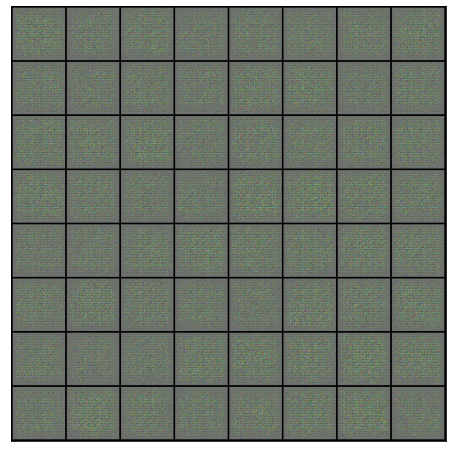

In [26]:
xb = to_device(torch.randn(batch_size, nz, 1, 1), device)
fake_imgs = netG(xb)
print(fake_imgs.shape)
show_images(denorm(fake_imgs.cpu()))

In [27]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

In [28]:
def train_discriminator(real_imgs, optimizerD):
  # Clear current gradients
  optimizerD.zero_grad()

  # Compute the loss on the real images
  real_preds = netD(real_imgs).view(-1)
  real_labels = torch.ones(real_imgs.size(0), 1, device=device).view(-1)
  real_loss = criterion(real_preds, real_labels)
  real_score = torch.mean(real_preds).item()

  # Compute the loss on fake images
  fake_imgs = netG(fixed_noise)
  fake_preds = netD(fake_imgs).view(-1)
  fake_labels = torch.zeros(fake_imgs.size(0), 1, device=device).view(-1)
  fake_loss = criterion(fake_preds, fake_labels)
  fake_score = torch.mean(fake_preds).item()

  # Combine both and update weights
  loss = real_loss + fake_loss
  loss.backward()
  optimizerD.step()
  
  return loss.item(), real_score, fake_score

In [29]:
def train_generator(optimizerG):
  # Clear the current gradients
  optimizerG.zero_grad()
  
  # Try to fool the discriminator (tell that all fakes are actually real)
  fake_imgs = netG(fixed_noise)
  preds = netD(fake_imgs).view(-1)
  targets = torch.ones(fake_imgs.size(0), 1, device=device).view(-1)
  loss = criterion(preds, targets)

  # Update weights
  loss.backward()
  optimizerG.step()

  return loss.item()

In [30]:
from tqdm.notebook import tqdm
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, show=True):
    fake_images = netG(fixed_noise)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(vutils.make_grid(fake_images.cpu().detach(), nrow=8, normalize=True).permute(1, 2, 0))

Saving generated-images-0000.png


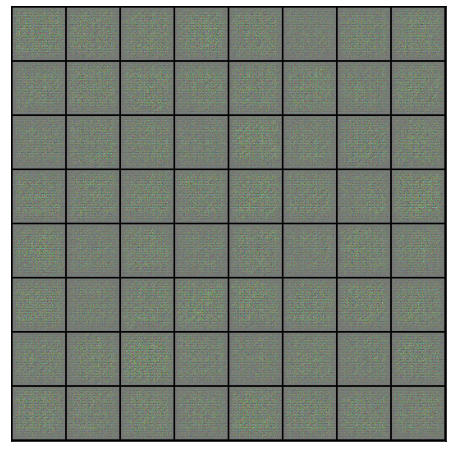

In [32]:
save_samples(0)

In [33]:
def fit(epochs):
  torch.cuda.empty_cache()

  # Keep track of losses and scores
  G_losses = []
  D_losses = []
  real_scores = []
  fake_scores = []
  img_list = []

  for epoch in range(epochs):
    for real_imgs, _ in tqdm(dataloader):
      d_loss, real_score, fake_score = train_discriminator(real_imgs, optimizerD)
      g_loss = train_generator(optimizerG)

    G_losses.append(g_loss)
    D_losses.append(d_loss)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, g_loss, d_loss, real_score, fake_score))
    
    generated_imgs = netG(fixed_noise)
    img_list.append(generated_imgs)
    save_samples(epoch+1, show=False)
    

  return G_losses, D_losses, real_scores, fake_scores, img_list


In [34]:
history = fit(50)


Epoch [1/50], loss_g: 2.8325, loss_d: 2.9925, real_score: 0.2317, fake_score: 0.0095
Saving generated-images-0001.png



Epoch [2/50], loss_g: 1.8741, loss_d: 0.7313, real_score: 0.8023, fake_score: 0.3886
Saving generated-images-0002.png



Epoch [3/50], loss_g: 0.8261, loss_d: 1.2125, real_score: 0.5485, fake_score: 0.4531
Saving generated-images-0003.png



Epoch [4/50], loss_g: 0.9770, loss_d: 1.2857, real_score: 0.5720, fake_score: 0.5130
Saving generated-images-0004.png



Epoch [5/50], loss_g: 0.8574, loss_d: 1.2278, real_score: 0.5095, fake_score: 0.4205
Saving generated-images-0005.png



Epoch [6/50], loss_g: 0.7116, loss_d: 1.3042, real_score: 0.4563, fake_score: 0.4001
Saving generated-images-0006.png



Epoch [7/50], loss_g: 0.9148, loss_d: 1.2041, real_score: 0.5633, fake_score: 0.4630
Saving generated-images-0007.png



Epoch [8/50], loss_g: 1.1012, loss_d: 1.1530, real_score: 0.5854, fake_score: 0.4566
Saving generated-images-0008.png



Epoch [9/50], loss_g: 1.1053, loss_d: 1.1168, real_score: 0.6054, fake_score: 0.4544
Saving generated-images-0009.png



Epoch [10/50], loss_g: 1.1164, loss_d: 1.1588, real_score: 0.6827, fake_score: 0.5355
Saving generated-images-0010.png



Epoch [11/50], loss_g: 0.7936, loss_d: 1.1521, real_score: 0.5667, fake_score: 0.4349
Saving generated-images-0011.png



Epoch [12/50], loss_g: 1.3653, loss_d: 1.3208, real_score: 0.6318, fake_score: 0.5691
Saving generated-images-0012.png



Epoch [13/50], loss_g: 0.9828, loss_d: 1.0801, real_score: 0.5429, fake_score: 0.3544
Saving generated-images-0013.png



Epoch [14/50], loss_g: 0.9451, loss_d: 1.0267, real_score: 0.5808, fake_score: 0.3649
Saving generated-images-0014.png



Epoch [15/50], loss_g: 0.7940, loss_d: 1.0207, real_score: 0.5652, fake_score: 0.3267
Saving generated-images-0015.png



Epoch [16/50], loss_g: 1.6886, loss_d: 0.8375, real_score: 0.7225, fake_score: 0.3842
Saving generated-images-0016.png



Epoch [17/50], loss_g: 1.8900, loss_d: 0.4426, real_score: 0.8076, fake_score: 0.1970
Saving generated-images-0017.png



Epoch [18/50], loss_g: 2.7282, loss_d: 0.4505, real_score: 0.9050, fake_score: 0.2908
Saving generated-images-0018.png



Epoch [19/50], loss_g: 1.9329, loss_d: 0.3921, real_score: 0.8172, fake_score: 0.1608
Saving generated-images-0019.png



Epoch [20/50], loss_g: 2.4168, loss_d: 0.3180, real_score: 0.8333, fake_score: 0.1211
Saving generated-images-0020.png



Epoch [21/50], loss_g: 1.9753, loss_d: 0.6439, real_score: 0.5680, fake_score: 0.0252
Saving generated-images-0021.png



Epoch [22/50], loss_g: 3.6950, loss_d: 0.1220, real_score: 0.9407, fake_score: 0.0580
Saving generated-images-0022.png



Epoch [23/50], loss_g: 1.8213, loss_d: 0.4657, real_score: 0.8824, fake_score: 0.2766
Saving generated-images-0023.png



Epoch [24/50], loss_g: 3.3471, loss_d: 0.1982, real_score: 0.9292, fake_score: 0.1142
Saving generated-images-0024.png



Epoch [25/50], loss_g: 3.7871, loss_d: 0.2043, real_score: 0.8695, fake_score: 0.0510
Saving generated-images-0025.png



Epoch [26/50], loss_g: 3.5041, loss_d: 0.0993, real_score: 0.9651, fake_score: 0.0608
Saving generated-images-0026.png



Epoch [27/50], loss_g: 7.8923, loss_d: 1.3769, real_score: 0.9903, fake_score: 0.7118
Saving generated-images-0027.png



Epoch [28/50], loss_g: 4.3179, loss_d: 0.0774, real_score: 0.9939, fake_score: 0.0684
Saving generated-images-0028.png



Epoch [29/50], loss_g: 3.7711, loss_d: 0.0724, real_score: 0.9713, fake_score: 0.0418
Saving generated-images-0029.png



Epoch [30/50], loss_g: 3.6817, loss_d: 0.1689, real_score: 0.9889, fake_score: 0.1427
Saving generated-images-0030.png



Epoch [31/50], loss_g: 2.7396, loss_d: 0.2672, real_score: 0.8015, fake_score: 0.0245
Saving generated-images-0031.png



Epoch [32/50], loss_g: 1.1630, loss_d: 0.3075, real_score: 0.7714, fake_score: 0.0305
Saving generated-images-0032.png



Epoch [33/50], loss_g: 3.5695, loss_d: 0.0889, real_score: 0.9783, fake_score: 0.0638
Saving generated-images-0033.png



Epoch [34/50], loss_g: 2.4337, loss_d: 0.1439, real_score: 0.8907, fake_score: 0.0239
Saving generated-images-0034.png



Epoch [35/50], loss_g: 2.8659, loss_d: 2.9265, real_score: 0.0842, fake_score: 0.0001
Saving generated-images-0035.png



Epoch [36/50], loss_g: 2.8590, loss_d: 0.2349, real_score: 0.9728, fake_score: 0.1739
Saving generated-images-0036.png



Epoch [37/50], loss_g: 3.9477, loss_d: 0.1322, real_score: 0.8987, fake_score: 0.0188
Saving generated-images-0037.png



Epoch [38/50], loss_g: 3.7512, loss_d: 0.0646, real_score: 0.9748, fake_score: 0.0377
Saving generated-images-0038.png



Epoch [39/50], loss_g: 4.9758, loss_d: 0.0158, real_score: 0.9962, fake_score: 0.0119
Saving generated-images-0039.png



Epoch [40/50], loss_g: 4.6121, loss_d: 0.0277, real_score: 0.9956, fake_score: 0.0229
Saving generated-images-0040.png



Epoch [41/50], loss_g: 3.7993, loss_d: 0.0681, real_score: 0.9896, fake_score: 0.0556
Saving generated-images-0041.png



Epoch [42/50], loss_g: 4.1373, loss_d: 0.0876, real_score: 0.9944, fake_score: 0.0778
Saving generated-images-0042.png



Epoch [43/50], loss_g: 4.6017, loss_d: 0.0287, real_score: 0.9971, fake_score: 0.0253
Saving generated-images-0043.png



Epoch [44/50], loss_g: 5.6087, loss_d: 0.0116, real_score: 0.9984, fake_score: 0.0099
Saving generated-images-0044.png



Epoch [45/50], loss_g: 4.5112, loss_d: 0.0475, real_score: 0.9859, fake_score: 0.0324
Saving generated-images-0045.png



Epoch [46/50], loss_g: 4.3591, loss_d: 0.0260, real_score: 0.9918, fake_score: 0.0175
Saving generated-images-0046.png



Epoch [47/50], loss_g: 3.8820, loss_d: 0.0641, real_score: 0.9805, fake_score: 0.0429
Saving generated-images-0047.png



Epoch [48/50], loss_g: 3.8161, loss_d: 0.0773, real_score: 0.9913, fake_score: 0.0658
Saving generated-images-0048.png



Epoch [49/50], loss_g: 4.9808, loss_d: 0.0200, real_score: 0.9942, fake_score: 0.0140
Saving generated-images-0049.png



Epoch [50/50], loss_g: 4.8330, loss_d: 0.0283, real_score: 0.9874, fake_score: 0.0154
Saving generated-images-0050.png


In [35]:
len(history)

5

In [36]:
G_losses = history[0]
D_losses = history[1]
real_scores = history[2]
fake_scores = history[3]
img_list = history[4]

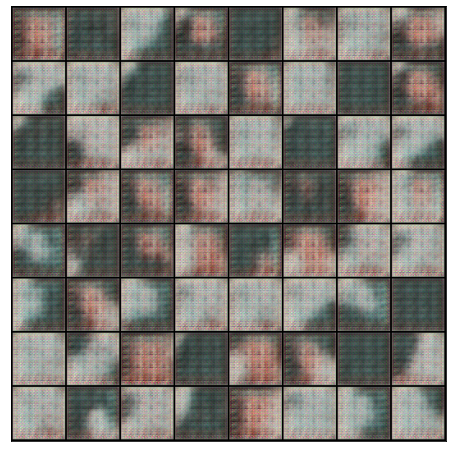

In [38]:
show_images(img_list[0].cpu())

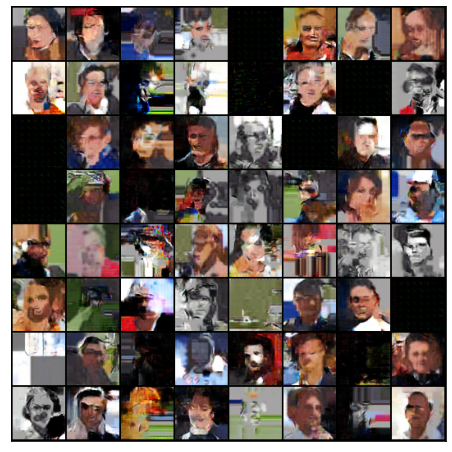

In [37]:
show_images(img_list[49].cpu())

In [39]:
#!zip -r generated.zip ./generated

Text(0.5, 1.0, 'Losses')

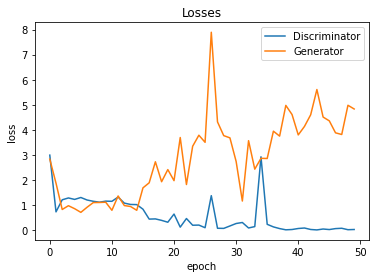

In [40]:
plt.plot(D_losses, '-')
plt.plot(G_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

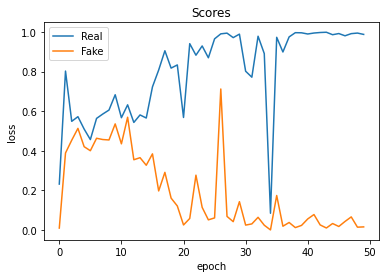

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

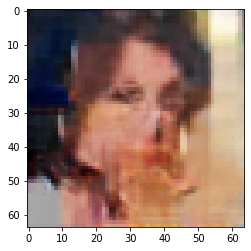

In [51]:
img = img_list[49][30].cpu().detach().permute(1, 2, 0)
img = img*0.5 + 0.5
plt.imshow(img)